In [12]:
from graph_tool.all import *
from graph_tool.stats import remove_parallel_edges
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

## Graph Generation

In [2]:
def create_d_ary(N,d) :
    g = Graph()
    g.add_vertex(N)
    pred_map = g.vertex_index.copy()

    for i in range(N) :
        pred_map[i] = np.floor((i+d-2)/d)
        
    return graph_tool.generation.predecessor_tree(g,pred_map)

def create_price_network(N) :
    return price_network(N)

## Propagation

In [49]:
#Chase_escape dans un arbre à attachement préférentiel, condition initi
def chase_escape_pn_init_1(g, l, n_iter) :

	N = g.num_vertices()
	M = g.num_edges()

	#Couleurs des sommets
	colors = g.new_vertex_property("string")
	colors[0] = 'blue'
	colors[1] = 'red'
	for i in range(2,N) :
		colors[i] = 'white'

	#Stockage des arêtes S-I et I-R
	edges = g.get_edges()
	edges_si = np.zeros(M)
	edges_ir = np.zeros(M)

	edges_ir[0] = 1

	nb = g.get_in_edges(1, [g.edge_index])[:,2]
	for i in nb :
		edges_si[i] = 1

	#Nombre d'arêtes dans chaque tableau
	n_si = len(nb)
	n_ir = 1

	#Iterations
	for i in range(n_iter) :

		if n_ir == 0 and n_si == 0 :
			break

		#Probabilité que I se propage avant R
		p = l*n_si/(l*n_si + n_ir)

		if (np.random.rand() <= p) : #I se propage avant

			#Choix d'une arête S-I
			idx = np.random.choice(range(M), size=1, p=edges_si/n_si)
			e = edges[idx][0]
			v = e[0]

			#Contamination du sommet sain
			colors[v] = 'red'
			edges_si[idx] = 0
	
			#Actualisation du vecteur des arêtes S-I
			nb = g.get_in_edges(v, [g.edge_index])[:,2]
			for i in nb :
				edges_si[i] = 1
			n_si += len(nb) - 1
		
		else : #R se propage avant

			#Choix d'une arête I-R
			idx = np.random.choice(range(M), size=1, p=edges_ir/n_ir)
			e = edges[idx][0]
			v = e[0]
		
			#Vaccination du sommet infecté
			colors[v] = 'blue'
			edges_ir[idx] = 0
			n_ir -= 1
	
			#Actualisation des vecteurs des arêtes S-I et I-R
			nb = g.get_in_edges(v, [g.edge_index])[:,2]
			for i in nb :
				if edges_si[i] == 1 :
					edges_si[i] = 0
					n_si -= 1
				else :
					edges_ir[i] = 1
					n_ir += 1
                    
	return colors

def chase_escape_d_init_1(g, l, n_iter) :

	N = g.num_vertices()
	M = g.num_edges()	

	#Couleurs des sommets
	colors = g.new_vertex_property("string")
	colors[0] = 'blue'
	colors[1] = 'red'
	for i in range(2,N) :
		colors[i] = 'white'

	#Stockage des arêtes S-I et I-R
	edges = g.get_edges()
	edges_si = np.zeros(M)
	edges_ir = np.zeros(M)

	edges_ir[0] = 1

	nb = g.get_out_edges(1, [g.edge_index])[:,2]
	for i in nb :
		edges_si[i] = 1

	#Nombre d'arêtes dans chaque tableau
	n_si = len(nb)
	n_ir = 1

	#Iterations
	for i in range(n_iter) :
		draw(g, colors, size=30, width=2, name='d_ary_{}.png'.format(i))

		if n_ir == 0 and n_si == 0 :
			break

		#Probabilité que I se propage avant R
		p = l*n_si/(l*n_si + n_ir)

		if (np.random.rand() <= p) : #I se propage avant

			#Choix d'une arête S-I
			idx = np.random.choice(range(M), size=1, p=edges_si/n_si)
			e = edges[idx][0]
			v = e[1]

			#Contamination du sommet sain
			colors[v] = 'red'
			edges_si[idx] = 0
	
			#Actualisation du vecteur des arêtes S-I
			nb = g.get_out_edges(v, [g.edge_index])[:,2]
			for i in nb :
				edges_si[i] = 1
			n_si += len(nb) - 1
		
		else : #R se propage avant

			#Choix d'une arête I-R
			idx = np.random.choice(range(M), size=1, p=edges_ir/n_ir)
			e = edges[idx][0]
			v = e[1]
		
			#Vaccination du sommet infecté
			colors[v] = 'blue'
			edges_ir[idx] = 0
			n_ir -= 1
	
			#Actualisation des vecteurs des arêtes S-I et I-R
			nb = g.get_out_edges(v, [g.edge_index])[:,2]
			for i in nb :
				if edges_si[i] == 1 :
					edges_si[i] = 0
					n_si -= 1
				else :
					edges_ir[i] = 1
					n_ir += 1
	return colors


## Drawing

In [4]:
def draw(g, c, size=8, width=0.1, name=None) :
	graph_draw(g, pos=sfdp_layout(g, cooling_step=0.99),vertex_fill_color=c, vertex_size=size, 
               edge_pen_width=width, output=name)

## Extinction probability

In [5]:
def estimate_extinction_prob_pn(N, l, n_iter):

	count = 0

	for _ in range(n_iter) :
		g = create_price_network(N)
		colors = chase_escape_pn_init_1(g, l, n_iter)
		if 'red' in colors :
			count += 1

	return count / n_iter

def estimate_extinction_prob_d(N, d, l, n_iter, n_iter_mc):

    count = 0
    g = create_d_ary(N, d)

    for _ in range(n_iter_mc):
        colors = chase_escape_d_init_1(g, l, n_iter)
        if 'red' in colors :
            count += 1

    return count / n_iter_mc


def plot_extinction_prob_pn(N, nb_iter):
	rates = np.arange(2, step = 0.01)
	extinction_probs = np.zeros(len(rates))

	for i in range(len(rates)):
		extinction_probs[i] = estimate_extinction_prob_pn(N, rates[i], nb_iter)

	plt.figure(figsize = (15, 10))
	plt.plot(rates, extinction_probs, 'o')
	plt.grid()
	plt.title("Probabilité d'extinction (N = {})".format(N))
	plt.xlabel("$\lambda$")
	plt.hlines(0.5, 0, 2, label = "$y = 0.5$")
	plt.legend()


def plot_extinction_prob_d(N, d, nb_iter, n_iter_mc):
    rates = np.arange(2, step = 0.01)
    extinction_probs = np.zeros(len(rates))

    for i in range(len(rates)):
        extinction_probs[i] = estimate_extinction_prob_d(N, d, rates[i], nb_iter, n_iter_mc)

    plt.figure(figsize = (15, 10))
    plt.plot(rates, extinction_probs, 'o')
    plt.plot(rates, rates*d/(rates*d +1), '-', c='orange')
    plt.grid()
    plt.title("Probabilité d'extinction (d = {})".format(d))
    plt.xlabel("$\lambda$")
    plt.ylabel("$P_\lambda(A)$")
    
    l_th = 2*d - 1 - 2*np.sqrt(d*d - d)
    
    plt.axvline(l_th, label = "$x = \lambda_c^{th}$", c='black')
    plt.legend()
    plt.savefig("plot_extinction_prob_{}.pdf".format(d))


## Critical rate evaluation

In [6]:
def crit_rate_pn(N, n_iter, d_l, eps) :

	l_c = d_l
	
	while l_c <= 1.0 :
		count = 0
		for _ in range(n_iter):
			g = create_price_network(N)
			colors = chase_escape_pn_init_1(g, l_c, n_iter)
			if 'white' in colors :
				count += 1
		if count/n_iter < eps :
			l_c += d_l
		else : 
			return (l_c - d_l)

def crit_rate_d(N, d, n_iter_mc, n_iter, d_l, eps) :

	l_c = d_l
	
	while l_c <= 1.0 :
		count = 0
		for _ in range(n_iter_mc):
			g = create_d_ary(N, d)
			colors = chase_escape_d_init_1(g, l_c, n_iter)
			if 'red' in colors :
				count += 1
		if count/n_iter_mc < eps :
			l_c += d_l
		else : 
			return (l_c - d_l)


In [7]:
def crit_rate_d(N, d, n_iter, d_l, n_iter_mc) :

    l_c = d_l
    
    while l_c <= 1.0 :
        g = create_d_ary(N, d)
        for _ in range(n_iter_mc) :
            colors = chase_escape_d_init_1(g, l_c, n_iter)
            if 'red' in colors :
                return (l_c - d_l)
            
        l_c += d_l
    return 1.0
        
def monte_carlo(nombre, N, d, n_iter, d_l, n_iter_mc) :
    l = 0.0
    for _ in range(nombre) :
        l += crit_rate_d(N, d, n_iter, d_l, n_iter_mc)
    return l/nombre


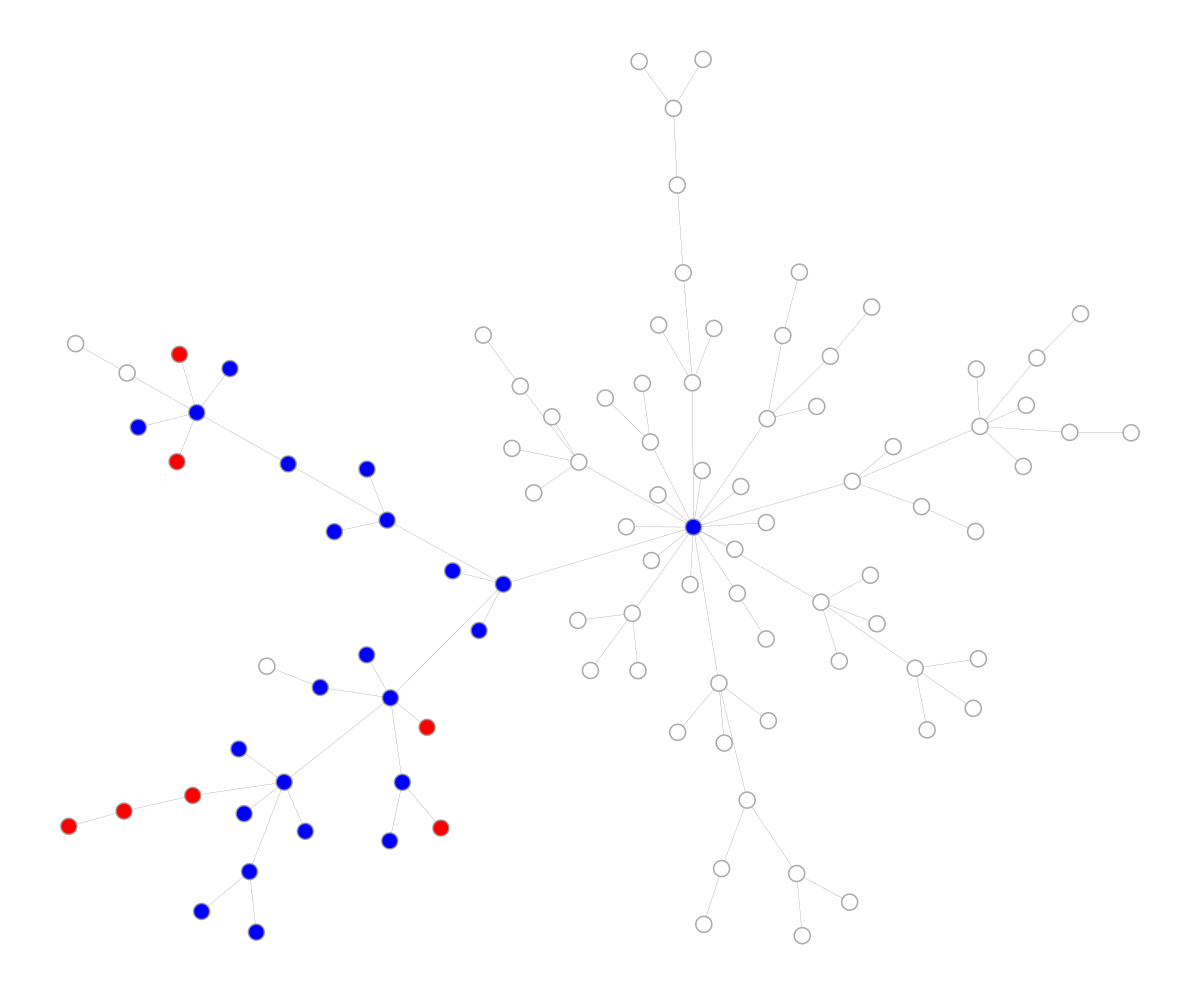

In [54]:
g = create_price_network(100)

c = chase_escape_pn_init_1(g, 1.0, 50)

draw(g, c)

#Observer le nombre/la proportion de sommet bleus en fonction de lambda (initialisation 2 points (pas forcément voisins) choisis au hasard)

In [53]:
g = create_d_ary(11,2)

c = chase_escape_d_init_1(g, 1.0, 4)

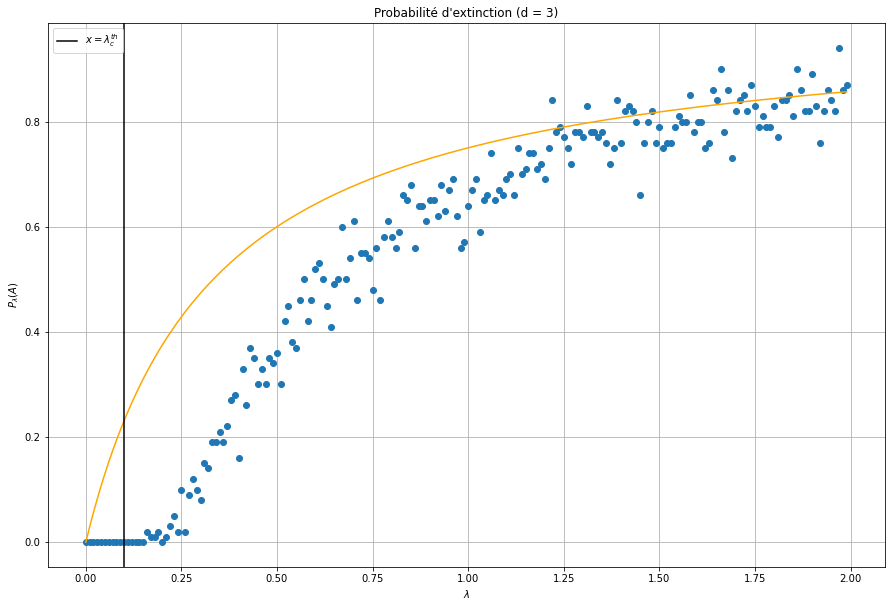

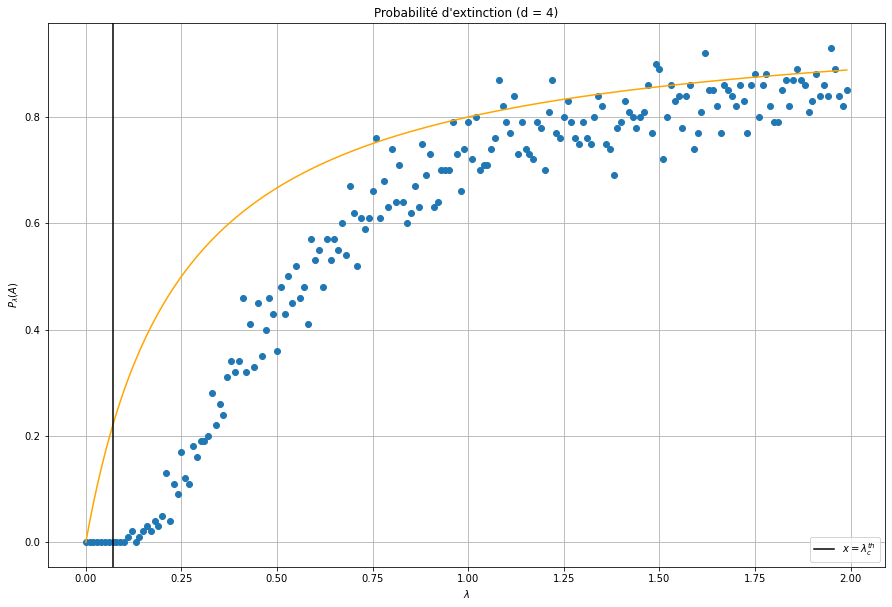

In [403]:
#plot_extinction_prob_d(500, 2, 50, 100)
plot_extinction_prob_d(500, 3, 50, 100)
plot_extinction_prob_d(500, 4, 50, 100)

In [92]:
monte_carlo(50, 500, 2, 50, 0.01, 500)

0.1754000000000001

No handles with labels found to put in legend.


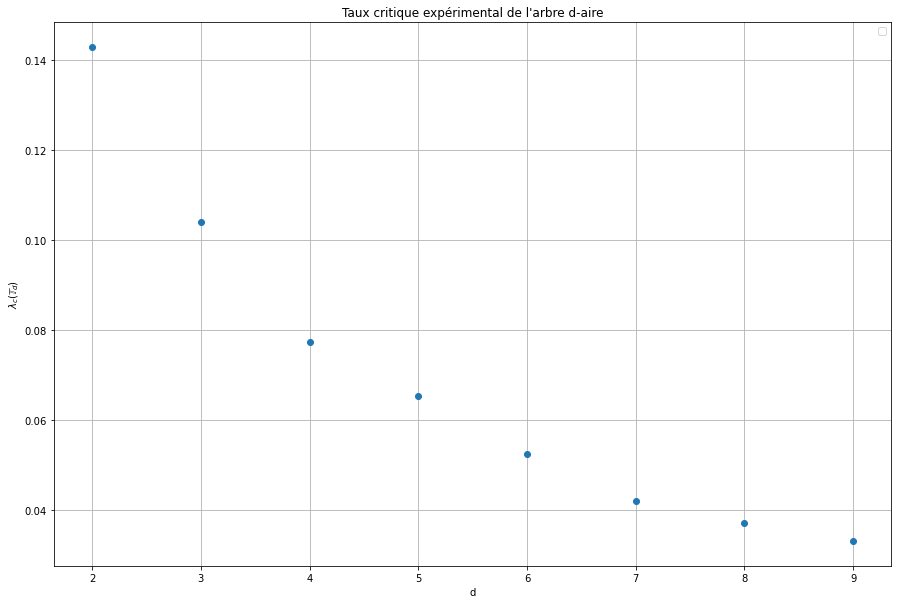

In [97]:
dim = np.arange(2,10)
size = np.array([500,500,1000,1000,3000,3000,5000,5000])

y = []

for i in range(8) :
    d = dim[i]
    N = size[i]
    y.append(monte_carlo(50, N, d, 50, 0.01, 500))
    
plt.figure(figsize = (15, 10))
plt.plot(dim, y, 'o')
plt.grid()
plt.title("Taux critique expérimental de l'arbre d-aire")
plt.ylabel("$\lambda_c(\mathbb{T}_d)$")
plt.xlabel("d")
plt.legend()
plt.savefig("lambda_c_d_aire")

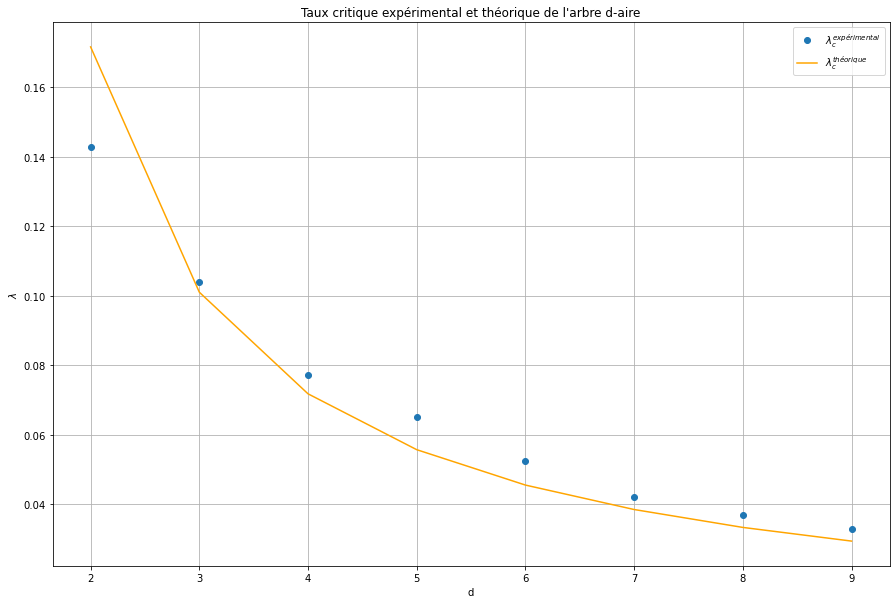

In [98]:
y2 = 2*dim - 1 - 2*np.sqrt(dim*dim - dim)

plt.figure(figsize = (15, 10))
plt.plot(dim, y, 'o', label='$\lambda_c^{expérimental}$')
plt.plot(dim, y2, '-', c='orange', label='$\lambda_c^{théorique}$')
plt.grid()
plt.title("Taux critique expérimental et théorique de l'arbre d-aire")
plt.ylabel("$\lambda$")
plt.xlabel("d")
plt.legend()
plt.savefig("lambda_c_d_aire.pdf")

## Randomization of the init cond for pn

In [8]:
def chase_escape_pn_init_2(g, l, n_iter) :

    N = g.num_vertices()
    M = g.num_edges()
    edges = g.get_edges()
    
    init = np.random.randint(M)
    v0 = edges[init, 0]
    v1 = edges[init, 1]
    #print(v0, v1)

    #Couleurs des sommets
    colors = g.new_vertex_property("string")
    for i in range(N) :
        colors[i] = 'white'
        
    colors[v0] = 'blue'
    colors[v1] = 'red'
    #print(colors[v1])
    
    #Stockage des arêtes S-I et I-R
    edges_si = np.zeros(M)
    edges_ir = np.zeros(M)

    edges_ir[init] = 1

    nb = g.get_all_edges(v1, [g.edge_index])[:,2]
    for i in nb :
        edges_si[i] = 1
    edges_si[init] = 0

    #Nombre d'arêtes dans chaque tableau
    n_si = len(nb)-1
    n_ir = 1

    #Iterations
    for n in range(n_iter) :

        if n_ir == 0 and n_si == 0 :
            break

        #Probabilité que I se propage avant R
        p = l*n_si/(l*n_si + n_ir)

        if (np.random.rand() <= p) : #I se propage avant

            #Choix d'une arête S-I
            idx = np.random.choice(range(M), size=1, p=edges_si/n_si)[0]
            e = edges[idx]
            if colors[e[0]] == 'red' :
                v = e[1]
            else :
                v = e[0]
                
            #print(e, colors[e[0]], colors[e[1]], v)

            #Contamination du sommet sain
            colors[v] = 'red'

            #Actualisation du vecteur des arêtes S-I
            nb = g.get_all_edges(v, [g.edge_index])[:,2]
            for i in nb :
                edges_si[i] = 1
                n_si += 1
            edges_si[idx] = 0
            n_si -= 2
        
        else : #R se propage avant

            #Choix d'une arête I-R
            idx = np.random.choice(range(M), size=1, p=edges_ir/n_ir)
            e = edges[idx][0]
            if colors[e[0]] == 'blue' :
                v = e[1]
            else :
                v = e[0]
        
            #Vaccination du sommet infecté
            colors[v] = 'blue'

            #Actualisation des vecteurs des arêtes S-I et I-R
            nb = g.get_all_edges(v, [g.edge_index])[:,2]
            for i in nb :
                if edges_si[i] == 1 :
                    edges_si[i] = 0
                    n_si -= 1
                else :
                    edges_ir[i] = 1
                    n_ir += 1
                    
            edges_ir[idx] = 0
            n_ir -= 2
                    
    return colors

In [41]:
g = create_price_network(100)

c = chase_escape_pn_init_2(g, 0.6, 50)

draw(g, c, name="ex_pn.png")

In [9]:
def crit_rate_pn(N, n_iter, d_l, n_iter_mc) :
    g = create_price_network(N)
    l_c = d_l
    
    while l_c <= 1.0 :
        
        for _ in range(n_iter_mc) :
            colors = chase_escape_pn_init_2(g, l_c, n_iter)
            if 'red' in colors :
                return (l_c - d_l)
                    
            
        l_c += d_l
    return 1.0



def monte_carlo_pn(nombre, N, n_iter, d_l, n_iter_mc) :
    g = create_price_network(N)
    res = 0.0
    
    for _ in range(nombre) :
        res += crit_rate_pn(g, N, n_iter, d_l, n_iter_mc)
    return res/nombre


In [443]:
g = create_price_network(30)

c = chase_escape_pn_init_2(g, 0.15, 0)

draw(g, c, name='init_pn1.pdf')

In [448]:
g = create_price_network(30)
c = chase_escape_pn_init_1(g, 0.15, 0)
c[0] = 'white'
c[1] = 'white'

c[g.get_edges()[-1,1]] = 'blue'
c[g.get_edges()[-1,0]] = 'red'

draw(g,c, name='init_pn1.pdf')

In [296]:
crit_rate_pn(500, 50, 0.05, 10)

0.2

In [10]:
def count_blue(colors) :
    count = 0
    for c in colors :
        if c == 'blue' :
            count += 1
    return count

def prop_bleu_pn(nombre, N, n_iter, l) :

    
    res = 0.0
    
    for _ in range(nombre) :
        g = create_price_network(N)
        colors = chase_escape_pn_init_2(g, l, n_iter)
        res += count_blue(colors)/N
            
        
    return res/nombre

In [315]:
echantillon = 50
size = np.zeros(echantillon*20)

for i in range(echantillon*20) :
    size[i] = 100 + 100 * (i%20)

/home/soubi/.conda/envs/map512/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


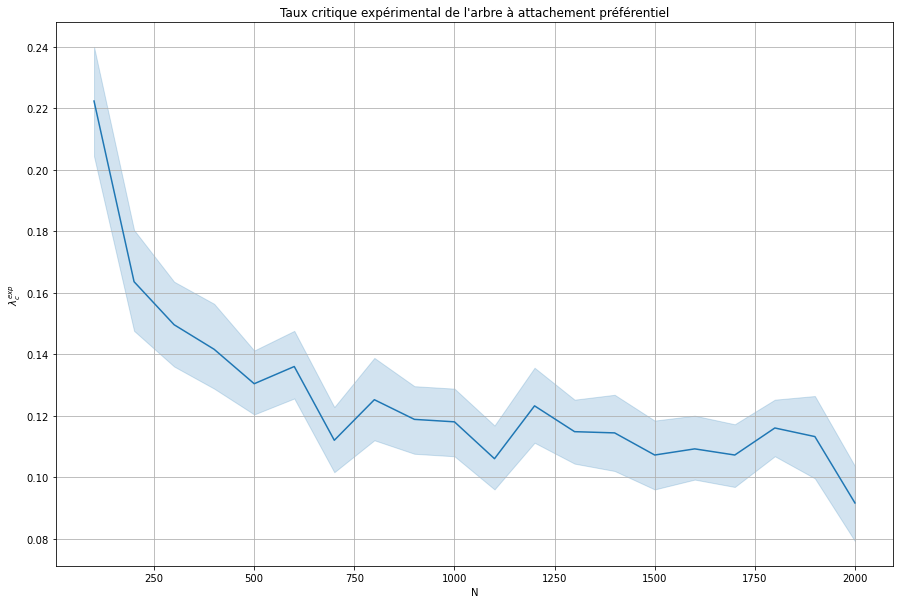

In [317]:
#y = np.zeros(len(size))

#for i in range(len(size)) :
    #N = size[i]
    #y[i] = crit_rate_pn(N, 50, 0.02, 10)


plt.figure(figsize = (15, 10))
sbs.lineplot(size, y)
#plt.plot(size, y, 'o')
plt.grid()
plt.title("Taux critique expérimental de l'arbre à attachement préférentiel")
plt.ylabel("$\lambda_c^{exp}$")
plt.xlabel("N")
plt.savefig("lambda_c_pn.pdf")

/home/soubi/.conda/envs/map512/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


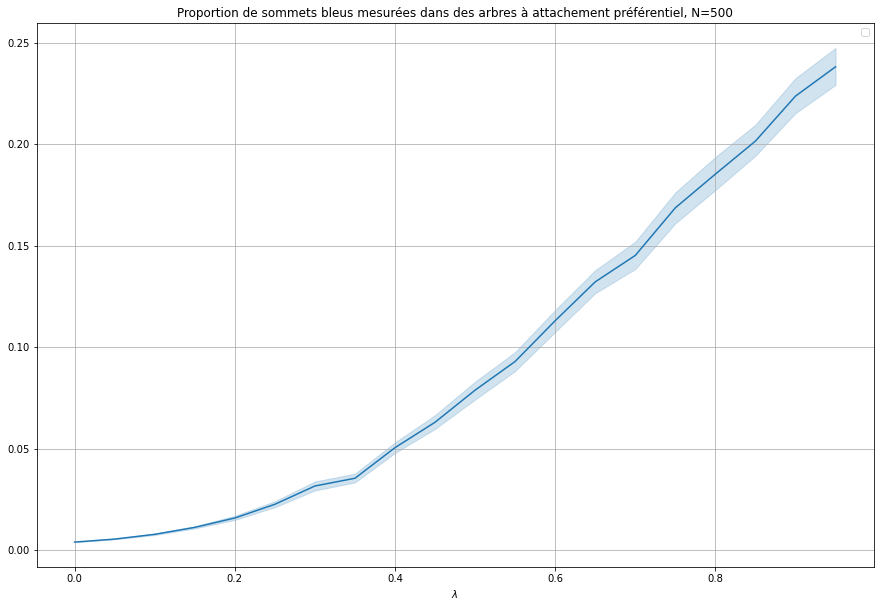

In [348]:
echantillon = 50
lambd = np.zeros(echantillon*40)

for i in range(echantillon*40) :
    lambd[i] = 0.05 * (i%20)

y = np.zeros(len(lambd))
N = 500

for i in range(len(lambd)) :
    l = lambd[i]
    y[i] = prop_bleu_pn(50, 500, 1000, l)


plt.figure(figsize = (15, 10))
sbs.lineplot(lambd, y)
#plt.plot(lambd,y,'o')
plt.grid()
plt.title("Proportion de sommets bleus mesurées dans des arbres à attachement préférentiel, N=500")
plt.xlabel("$\lambda$")
plt.legend()
plt.savefig("prop_bleu_pn.pdf")

# Simulation of a graph adapted to social network

In [54]:
with open('matrix/adj_matrix.txt', 'r') as f:
    l = [[int(num) for num in line.split(' ')] for line in f]

m = np.array(l)

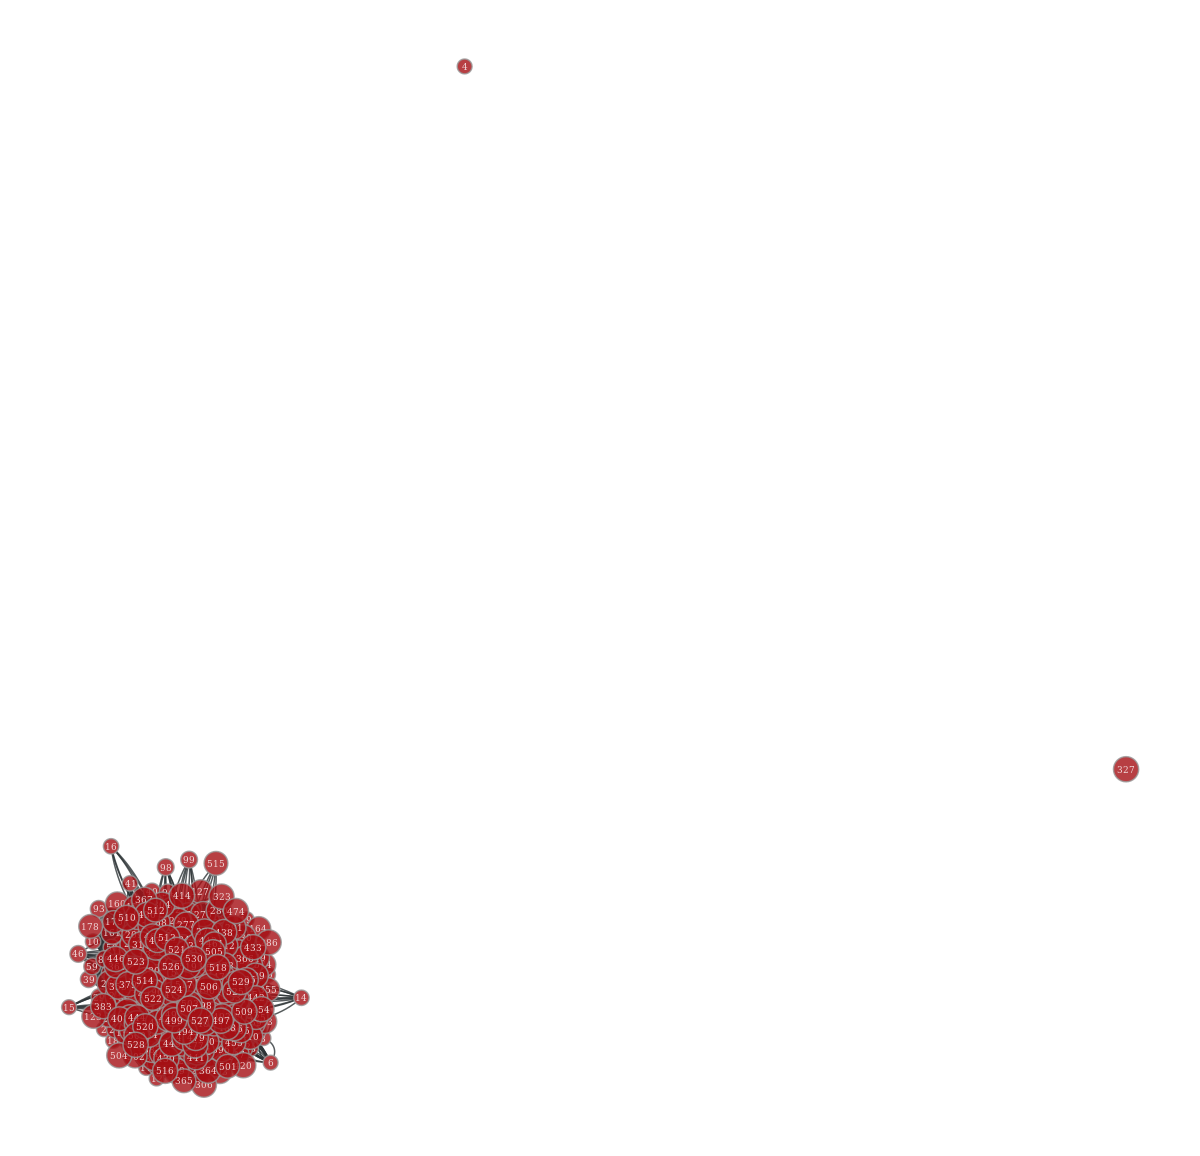

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f678f144cd0, at 0x7f67ec4d6550>

In [55]:
g = Graph(directed=False)

g.add_edge_list(np.transpose(m.nonzero()))

graph_draw(g, pos=sfdp_layout(g, cooling_step=0.99),vertex_text=g.vertex_index)

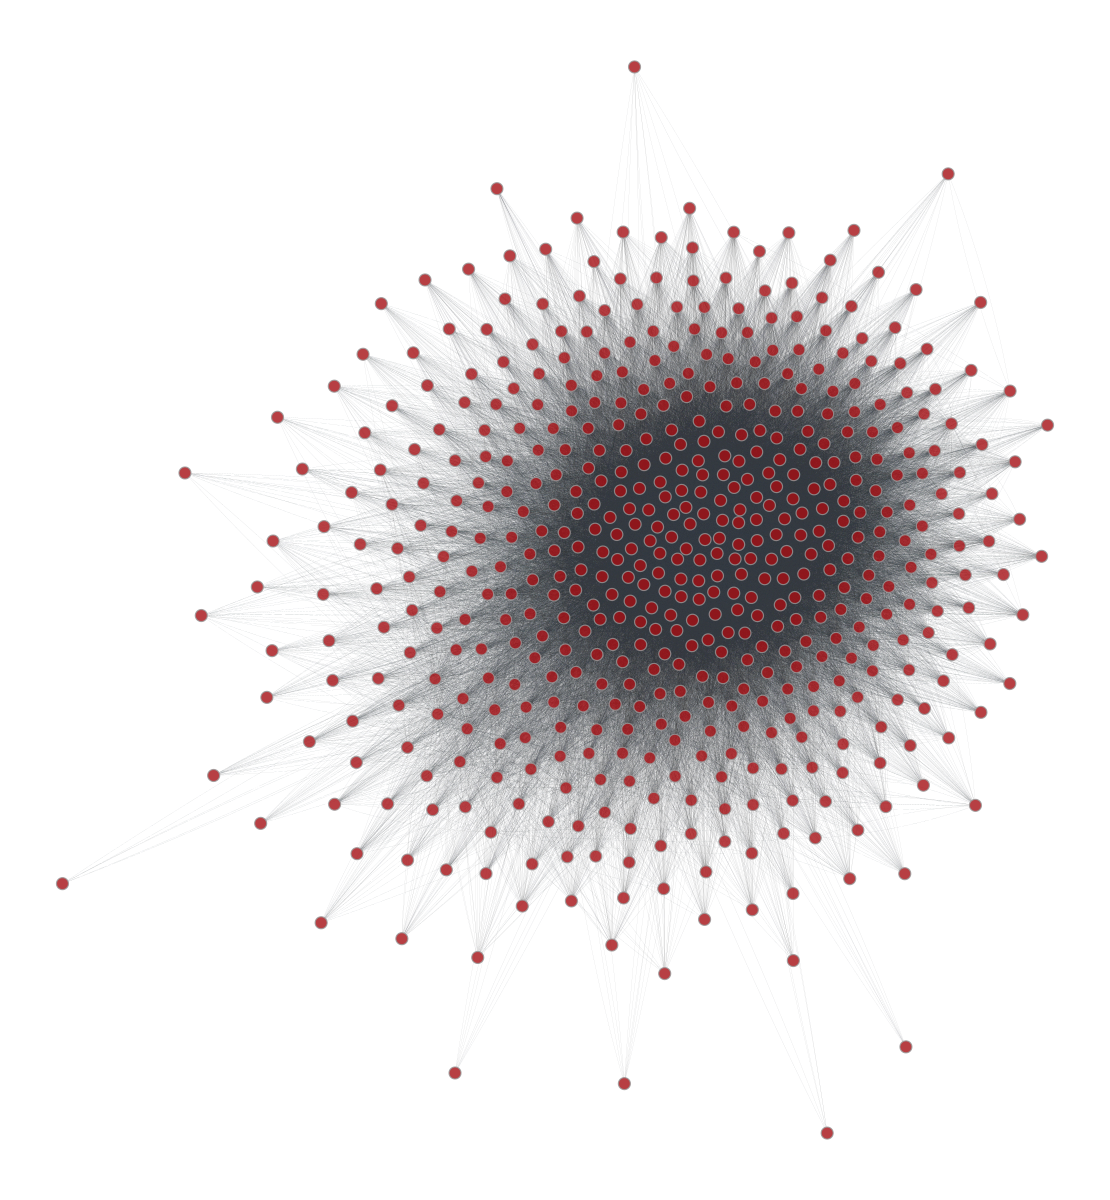

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f678f144cd0, at 0x7f678f144f10>

In [56]:
g.remove_vertex([4,326,327])
g.reindex_edges()

graph_draw(g, pos=sfdp_layout(g, cooling_step=0.99), vertex_size=6, edge_pen_width=0.01)

In [57]:
remove_parallel_edges(g)
g.reindex_edges()

In [68]:
graph_draw(g, pos=sfdp_layout(g, cooling_step=0.99), vertex_size=8, vertex_fill_color='white', edge_pen_width=0.1, output="final_graph1.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f678f144cd0, at 0x7f678f144fd0>

In [24]:
def susceptible(e, colors) :
    if colors[e[0]] == 'white' :
        return e[0]
    else :
        return e[1]
    
    
def infected(e, colors) :
    if colors[e[0]] == 'blue' :
        return e[1]
    else :
        return e[0]
    
def neighbor(e, v) :
    if e[0] == v :
        return e[1]
    else :
        return e[0]
    

def chase_escape_sbm_init_1(g, l, n_iter) :

    N = g.num_vertices()
    M = g.num_edges()

    #Couleurs des sommets
    colors = g.new_vertex_property("string")
    for i in range(N) :
        colors[i] = 'white'
    colors[0] = 'blue'

    #Stockage des arêtes S-I et I-R
    edges = g.get_edges()
    edges_si = np.zeros(M)
    edges_ir = np.zeros(M)

    edges_ir[0] = 1
    n_ir = 1
    n_si = 0
    
    v1 = edges[0,1]
    colors[v1] = 'red'

    nb = g.get_all_edges(v1, [g.edge_index])[:,2]
    for i in nb :
            edges_si[i] = 1
            n_si += 1
            
    edges_si[0] = 0
    n_si -= 1
    
    #Iterations
    for i in range(n_iter) :

        if n_ir == 0 and n_si == 0 :
            break

        #Probabilité que I se propage avant R
        p = l*n_si/(l*n_si + n_ir)
        #print(n_si,n_ir)
        #print('p = ',p)

        if (np.random.rand() <= p) : #I se propage avant

            #Choix d'une arête S-I
            #print('Susceptible infected')
            idx = np.random.choice(range(M), size=1, p=edges_si/n_si)
            
            e = edges[idx][0]
            v = susceptible(e, colors)

            #Contamination du sommet sain
            colors[v] = 'red'
            #edges_si[idx] = 0
            #n_si -= 1
    
            #Actualisation du vecteur des arêtes S-I
            nb = g.get_all_edges(v, [g.edge_index])
            #print(v)
            for ed in nb : #L'indexation de g.edge_index n'est pas celle de edges
                i = ed[2]
                #print('color of ', neighbor(edges[i], v), ' : ', colors[neighbor(edges[i], v)])
                #print(neighbor(edges[i], v))
                c = colors[neighbor(edges[i], v)]
                if  c == 'white' :
                    if edges_si[i] == 1 :
                        print('ALERTE 1 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 1
                    n_si += 1
                elif c == 'red' :
                    if edges_si[i] == 0 :
                        print('ALERTE 2 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 0
                    n_si -= 1
                else :
                    if edges_ir[i] == 1 :
                        print('ALERTE 3 : ', ed, colors[ed[0]], colors[ed[1]])
                    #print(edges[i])
                    edges_ir[i] = 1
                    n_ir += 1
        
        else : #R se propage avant

            #Choix d'une arête I-R
            #print('Infected recovered')
            idx = np.random.choice(range(M), size=1, p=edges_ir/n_ir)
            e = edges[idx][0]
            v = infected(e, colors)
        
            #Vaccination du sommet infecté
            colors[v] = 'blue'
            #print(v)
    
            #Actualisation des vecteurs des arêtes S-I et I-R
            nb = g.get_all_edges(v, [g.edge_index])
            #print(v)
            for ed in nb : #L'indexation de g.edge_index n'est pas celle de edges
                i = ed[2]
                #print('color of ', neighbor(edges[i], v), ' : ', colors[neighbor(edges[i], v)])
                #print(neighbor(edges[i], v))
                c = colors[neighbor(edges[i], v)]
                #print(ed, c)
                if c == 'white' :
                    if edges_si[i] == 0 :
                        print('ALERTE 1 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 0
                    n_si -= 1
                elif c == 'red' :
                    if edges_ir[i] == 1 :
                        print('ALERTE 2 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_ir[i] = 1
                    n_ir += 1
                else :
                    if edges_ir[i] == 0 :
                        print('ALERTE 3 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_ir[i] = 0
                    n_ir -= 1
                    
        
    return colors

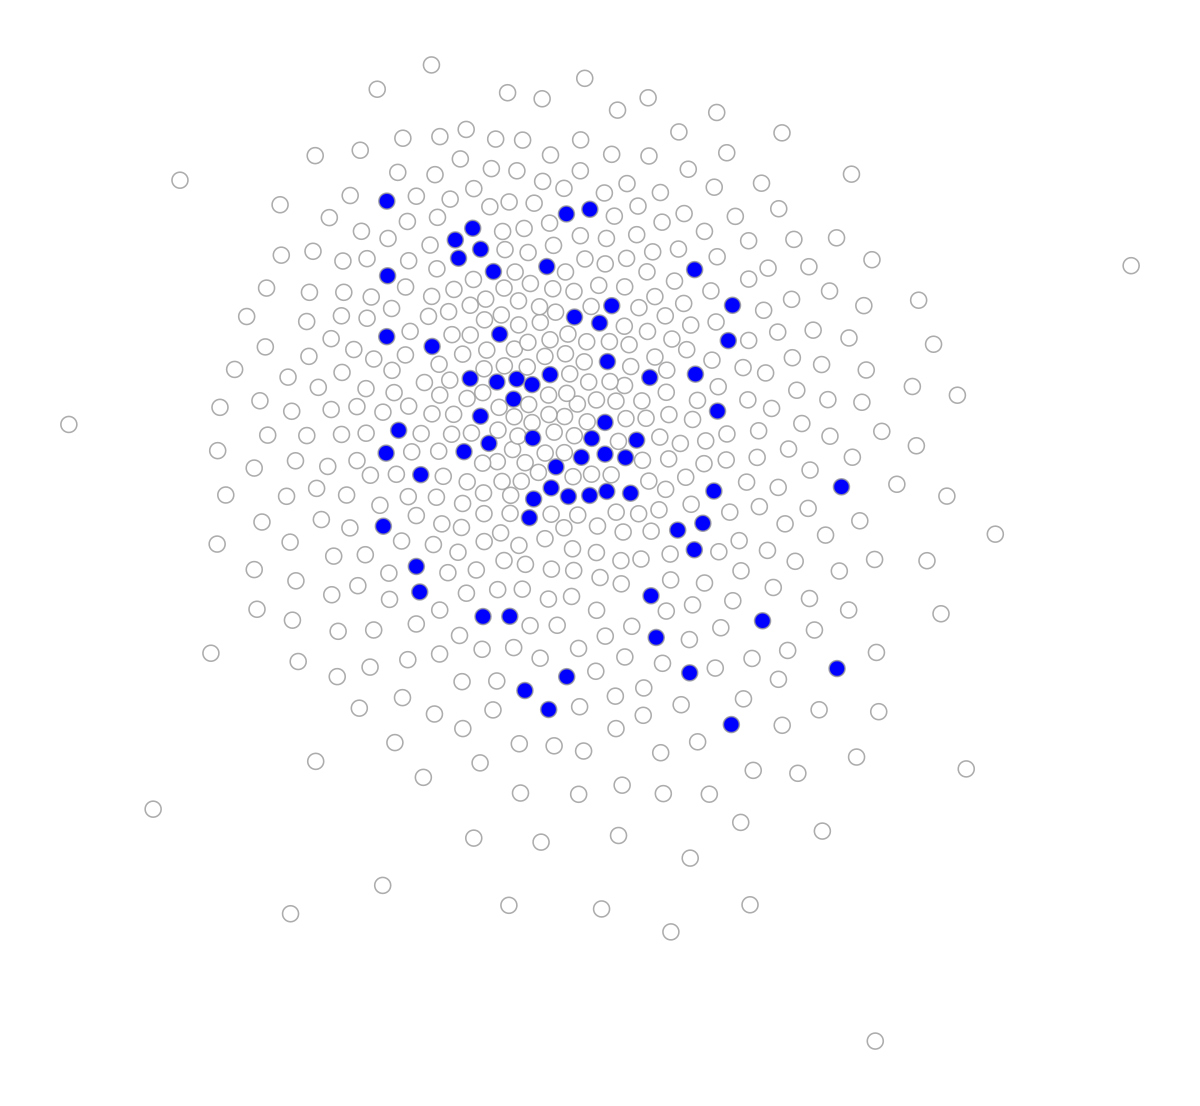

In [210]:
c = chase_escape_sbm_init_1(g, 0.05, 200)

draw(g, c, width=0.001)

## Randomization of the init cond

In [25]:
def chase_escape_sbm_init_2(g, l, n_iter) :

    N = g.num_vertices()
    M = g.num_edges()
    init = np.random.randint(M)
    edges = g.get_edges()
    v0 = edges[init, 0]
    v1 = edges[init, 1]
    
    #Couleurs des sommets
    colors = g.new_vertex_property("string")
    for i in range(N) :
        colors[i] = 'white'
    colors[v0] = 'blue'
    colors[v1] = 'red'
    
    #Stockage des arêtes S-I et I-R
    edges_si = np.zeros(M)
    edges_ir = np.zeros(M)

    edges_ir[init] = 1
    n_ir = 1
    n_si = 0
    

    nb = g.get_all_edges(v1, [g.edge_index])[:,2]
    for i in nb :
            edges_si[i] = 1
            n_si += 1
            
    edges_si[init] = 0
    n_si -= 1
    
    #Iterations
    for i in range(n_iter) :

        if n_ir == 0 and n_si == 0 :
            break

        #Probabilité que I se propage avant R
        p = l*n_si/(l*n_si + n_ir)
        #print(n_si,n_ir)
        #print('p = ',p)

        if (np.random.rand() <= p) : #I se propage avant

            #Choix d'une arête S-I
            #print('Susceptible infected')
            idx = np.random.choice(range(M), size=1, p=edges_si/n_si)
            
            e = edges[idx][0]
            v = susceptible(e, colors)

            #Contamination du sommet sain
            colors[v] = 'red'
            #edges_si[idx] = 0
            #n_si -= 1
    
            #Actualisation du vecteur des arêtes S-I
            nb = g.get_all_edges(v, [g.edge_index])
            #print(v)
            for ed in nb :
                i = ed[2]
                #print('color of ', neighbor(edges[i], v), ' : ', colors[neighbor(edges[i], v)])
                #print(neighbor(edges[i], v))
                c = colors[neighbor(edges[i], v)]
                if  c == 'white' :
                    if edges_si[i] == 1 :
                        print('ALERTE 1 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 1
                    n_si += 1
                elif c == 'red' :
                    if edges_si[i] == 0 :
                        print('ALERTE 2 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 0
                    n_si -= 1
                else :
                    if edges_ir[i] == 1 :
                        print('ALERTE 3 : ', ed, colors[ed[0]], colors[ed[1]])
                    #print(edges[i])
                    edges_ir[i] = 1
                    n_ir += 1
        
        else : #R se propage avant

            #Choix d'une arête I-R
            #print('Infected recovered')
            idx = np.random.choice(range(M), size=1, p=edges_ir/n_ir)
            e = edges[idx][0]
            v = infected(e, colors)
        
            #Vaccination du sommet infecté
            colors[v] = 'blue'
            #print(v)
    
            #Actualisation des vecteurs des arêtes S-I et I-R
            nb = g.get_all_edges(v, [g.edge_index])
            #print(v)
            for ed in nb : #L'indexation de g.edge_index n'est pas celle de edges
                i = ed[2]
                #print('color of ', neighbor(edges[i], v), ' : ', colors[neighbor(edges[i], v)])
                #print(neighbor(edges[i], v))
                c = colors[neighbor(edges[i], v)]
                #print(ed, c)
                if c == 'white' :
                    if edges_si[i] == 0 :
                        print('ALERTE 1 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 0
                    n_si -= 1
                elif c == 'red' :
                    if edges_ir[i] == 1 :
                        print('ALERTE 2 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_ir[i] = 1
                    n_ir += 1
                else :
                    if edges_ir[i] == 0 :
                        print('ALERTE 3 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_ir[i] = 0
                    n_ir -= 1
                    
        
    return colors

In [75]:
c = chase_escape_sbm_init_2(g, 0.04, 100)

graph_draw(g, pos=sfdp_layout(g, cooling_step=0.99), vertex_size=8, vertex_fill_color=c, edge_pen_width=0.1, output="final_graph2.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f678f144cd0, at 0x7f678f23e490>

In [385]:
def crit_rate_sbm(nombre, g, n_iter, d_l, n_iter_mc) :

    res = []
    
    
    for _ in range(nombre) :
        l_c = d_l

        while l_c < 1.0 :
            for _ in range(n_iter_mc) :
                colors = chase_escape_sbm_init_2(g, l_c, n_iter)
                if 'red' in colors :
                    res.append(l_c)
                    #print(l_c)
                    l_c = 2.0
                    break
            
            else :
                l_c += d_l
                

            
    return res

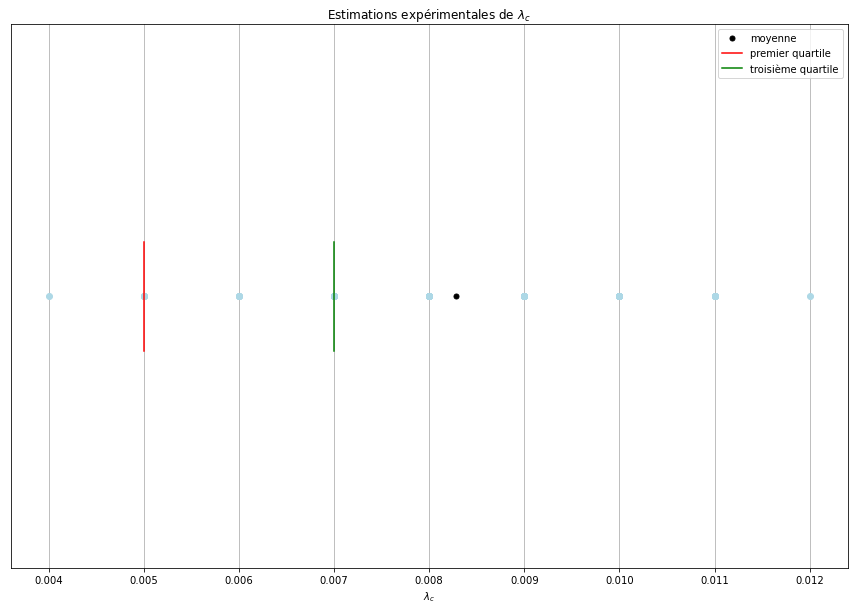

In [390]:
#x = crit_rate_sbm(50, g, 50, 0.001, 30)
#y = np.zeros(len(x))

plt.figure(figsize = (15, 10))
plt.plot(x,y,'o',c='lightblue')
plt.plot(np.mean(x),[0],'o',ms=5, c='black', label='moyenne')

np.sort(x)
plt.axvline(x[7], 0.4, 0.6, label = "premier quartile", c='red')
plt.axvline(x[23], 0.4, 0.6, label = "troisième quartile", c='green')
plt.legend()
plt.grid()
plt.title("Estimations expérimentales de $\lambda_c$")
plt.xlabel("$\lambda_c$")
plt.yticks([])
plt.savefig("lambda_c_sbm.pdf")

In [396]:
def prop_bleu_sbm(nombre, g, n_iter, l) :

    N = g.num_vertices()
    res = 0.0
    
    for _ in range(nombre) :
        colors = chase_escape_sbm_init_2(g, l, n_iter)
        res += count_blue(colors)/N
            
    print(l)    
    return res/nombre

/home/soubi/.conda/envs/map512/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


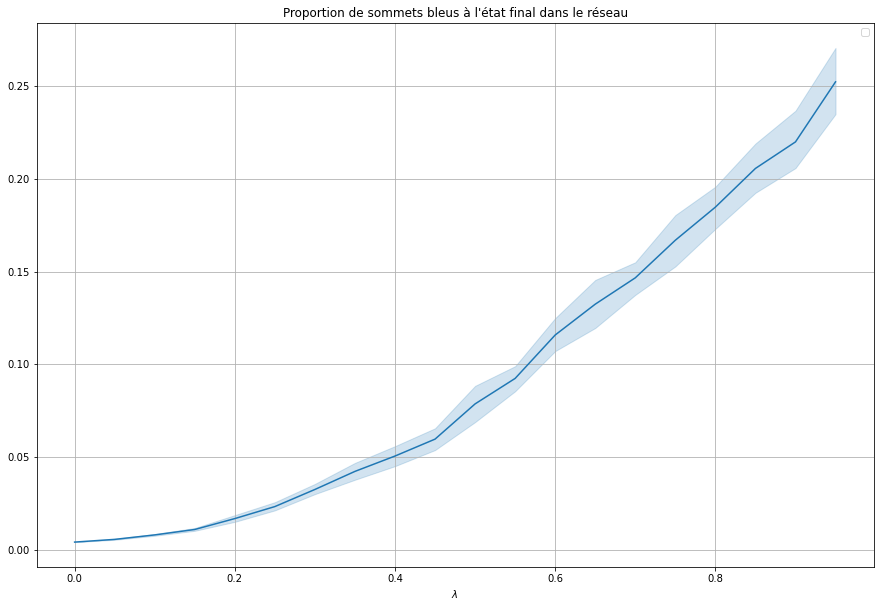

In [397]:
echantillon = 30
lambd = np.zeros(echantillon*20)

for i in range(echantillon*20) :
    lambd[i] = 0.05 * (i%20)

y = np.zeros(len(lambd))
N = 500

for i in range(len(lambd)) :
    l = lambd[i]
    y[i] = prop_bleu_pn(50, 500, 1000, l)


plt.figure(figsize = (15, 10))
sbs.lineplot(lambd, y)
#plt.plot(lambd,y,'o')
plt.grid()
plt.title("Proportion de sommets bleus à l'état final dans le réseau")
plt.xlabel("$\lambda$")
plt.legend()
plt.savefig("prop_bleu_sbm.pdf")

In [33]:
g = complete_graph(20)

c = chase_escape_sbm_init_2(g, 0.5, 10)

#graph_draw(g, edge_pen_width=0.2)
draw(g,c,size=30, width=0.2, name='complet_graph.png')

In [84]:
def chase_escape_sbm_init_3(g, l, n_iter, init) :

    N = g.num_vertices()
    M = g.num_edges()
    #init = np.random.randint(M)
    edges = g.get_edges()
    v0 = edges[init, 0]
    v1 = edges[init, 1]
    
    #Couleurs des sommets
    colors = g.new_vertex_property("string")
    for i in range(N) :
        colors[i] = 'white'
    colors[v0] = 'blue'
    colors[v1] = 'red'
    
    #Stockage des arêtes S-I et I-R
    edges_si = np.zeros(M)
    edges_ir = np.zeros(M)

    edges_ir[init] = 1
    n_ir = 1
    n_si = 0
    

    nb = g.get_all_edges(v1, [g.edge_index])[:,2]
    for i in nb :
            edges_si[i] = 1
            n_si += 1
            
    edges_si[init] = 0
    n_si -= 1
    
    #Iterations
    for i in range(n_iter) :

        if n_ir == 0 and n_si == 0 :
            break

        #Probabilité que I se propage avant R
        p = l*n_si/(l*n_si + n_ir)
        #print(n_si,n_ir)
        #print('p = ',p)

        if (np.random.rand() <= p) : #I se propage avant

            #Choix d'une arête S-I
            #print('Susceptible infected')
            idx = np.random.choice(range(M), size=1, p=edges_si/n_si)
            
            e = edges[idx][0]
            v = susceptible(e, colors)

            #Contamination du sommet sain
            colors[v] = 'red'
            #edges_si[idx] = 0
            #n_si -= 1
    
            #Actualisation du vecteur des arêtes S-I
            nb = g.get_all_edges(v, [g.edge_index])
            #print(v)
            for ed in nb :
                i = ed[2]
                #print('color of ', neighbor(edges[i], v), ' : ', colors[neighbor(edges[i], v)])
                #print(neighbor(edges[i], v))
                c = colors[neighbor(edges[i], v)]
                if  c == 'white' :
                    if edges_si[i] == 1 :
                        print('ALERTE 1 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 1
                    n_si += 1
                elif c == 'red' :
                    if edges_si[i] == 0 :
                        print('ALERTE 2 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 0
                    n_si -= 1
                else :
                    if edges_ir[i] == 1 :
                        print('ALERTE 3 : ', ed, colors[ed[0]], colors[ed[1]])
                    #print(edges[i])
                    edges_ir[i] = 1
                    n_ir += 1
        
        else : #R se propage avant

            #Choix d'une arête I-R
            #print('Infected recovered')
            idx = np.random.choice(range(M), size=1, p=edges_ir/n_ir)
            e = edges[idx][0]
            v = infected(e, colors)
        
            #Vaccination du sommet infecté
            colors[v] = 'blue'
            #print(v)
    
            #Actualisation des vecteurs des arêtes S-I et I-R
            nb = g.get_all_edges(v, [g.edge_index])
            #print(v)
            for ed in nb : #L'indexation de g.edge_index n'est pas celle de edges
                i = ed[2]
                #print('color of ', neighbor(edges[i], v), ' : ', colors[neighbor(edges[i], v)])
                #print(neighbor(edges[i], v))
                c = colors[neighbor(edges[i], v)]
                #print(ed, c)
                if c == 'white' :
                    if edges_si[i] == 0 :
                        print('ALERTE 1 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_si[i] = 0
                    n_si -= 1
                elif c == 'red' :
                    if edges_ir[i] == 1 :
                        print('ALERTE 2 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_ir[i] = 1
                    n_ir += 1
                else :
                    if edges_ir[i] == 0 :
                        print('ALERTE 3 : ', ed, colors[ed[0]], colors[ed[1]])
                    edges_ir[i] = 0
                    n_ir -= 1
                    
        
    return colors

In [98]:
def crit_rate_sbm_3(g, n_iter, d_l, n_iter_mc, init) :
    l_c = d_l
    
    while l_c <= 1.0 :
        
        for _ in range(n_iter_mc) :
            colors = chase_escape_sbm_init_3(g, l_c, n_iter, init)
            if 'red' in colors :
                return (l_c - d_l)
                    
            
        l_c += d_l
    return 1.0

def mc_sbm(nombre, g, n_iter, d_l, n_iter_mc, init) :
    res = 0
    for _ in range(nombre) :
        res += crit_rate_sbm_3(g, n_iter, d_l, n_iter_mc, init)
    return res/nombre

/home/soubi/.conda/envs/map512/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


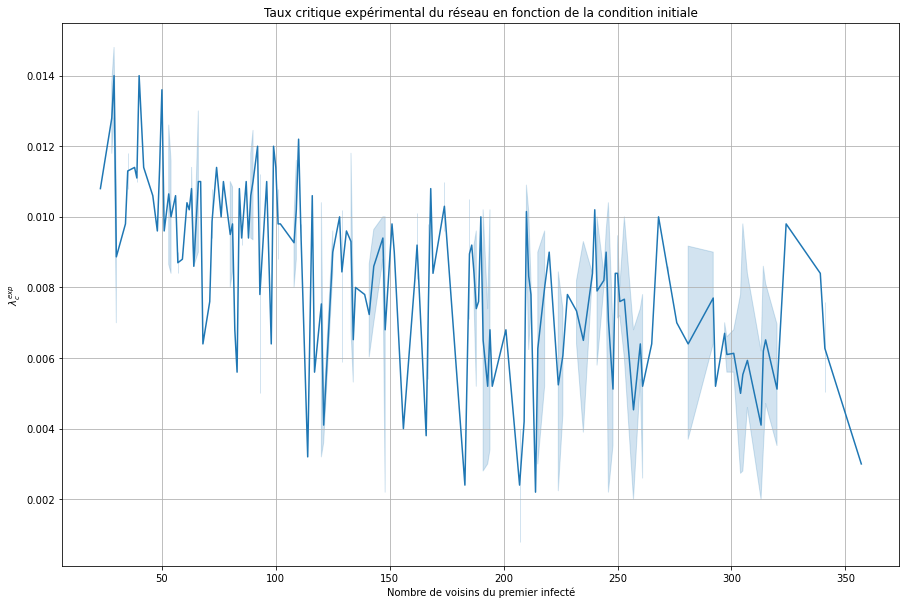

In [101]:
echantillon = 300
n_mc1 = 50
n_mc2 = 10

y = np.zeros(echantillon)
x = np.zeros(echantillon)
deg = g.degree_property_map('total')

for i in range(echantillon) :
    init = np.random.randint(g.num_edges())
    v1 = g.get_edges()[init, 1]
    
    x[i] = deg[v1]
    y[i] = mc_sbm(n_mc1, g, 50, 0.01, n_mc2, init)


plt.figure(figsize = (15, 10))
sbs.lineplot(x, y)
#plt.plot(size, y, 'o')
plt.grid()
plt.title("Taux critique expérimental du réseau en fonction de la condition initiale")
plt.ylabel("$\lambda_c^{exp}$")
plt.xlabel("Nombre de voisins du premier infecté")
plt.savefig("lambda_c_pn2.pdf")

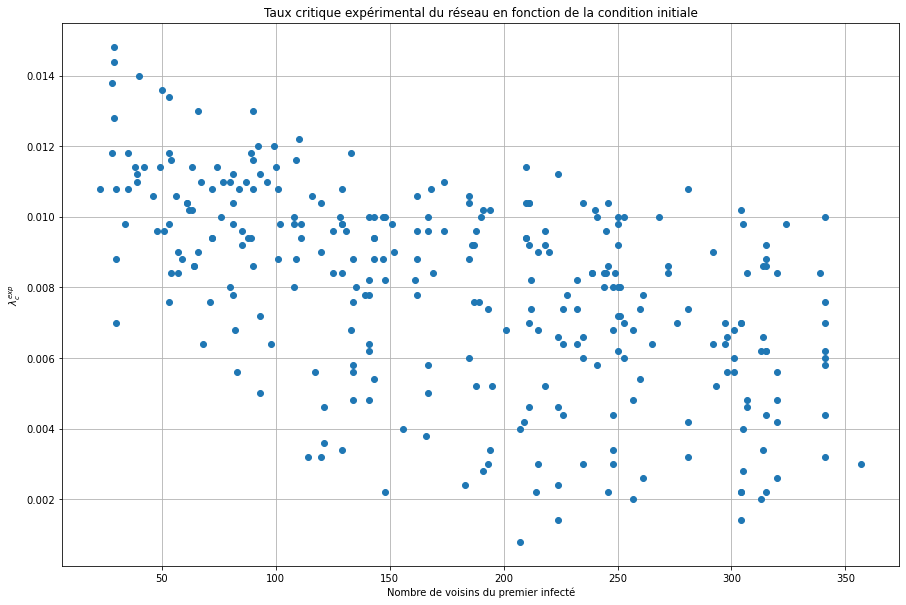

In [103]:
plt.figure(figsize = (15, 10))
#sbs.lineplot(x, y)
plt.plot(x, y, 'o')
plt.grid()
plt.title("Taux critique expérimental du réseau en fonction de la condition initiale")
plt.ylabel("$\lambda_c^{exp}$")
plt.xlabel("Nombre de voisins du premier infecté")
plt.savefig("lambda_c_pn2.pdf")

In [110]:
deg = g.degree_property_map('total')
np.mean(deg.a)

PropertyArray(108.25)